<a href="https://colab.research.google.com/github/mmosaffa/A-novel-Convolutional-Neural-Network-Architecture-for-distinguishing-Pneumonia-X-ray-Images-process/blob/main/CNN%20for%20X-ray%20Image%20Processing_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Saving kaggle.json to kaggle.json
ref                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/date-fruit-datasets                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39           1805        326  0.9375           
datasets/piterfm/2022-ukraine-russian-war                      2022 Ukraine Russia War                            2KB  2022-04-21 09:38:14          10253        561  1.0              
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36            215        287  0.9375           
datasets/kamilpytlak/personal-key-indicators-o

In [ ]:
  !unzip chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import os 
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [ ]:
img_size = 200
labels = ['PNEUMONIA', 'NORMAL']

def get_training_data(data_dir):
    data = list()
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/chest_xray/train')
test = get_training_data('/content/chest_xray/test')
val = get_training_data('/content/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [ ]:
print(f"Train: {len(train)}, Test: {len(test)}")

Train: 5216, Test: 624


Text(0.5, 1.0, 'NORMAL')

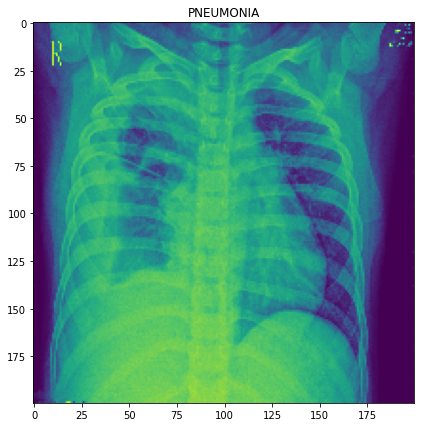

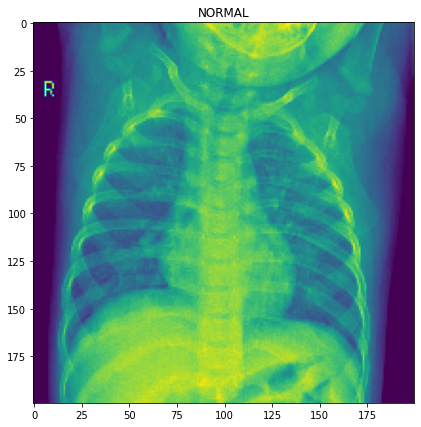

In [ ]:
plt.figure(figsize = (7, 7))
plt.imshow(train[10][0])
plt.title(labels[train[10][1]])

plt.figure(figsize = (7, 7))
plt.imshow(train[4003][0])
plt.title(labels[train[4003][1]])

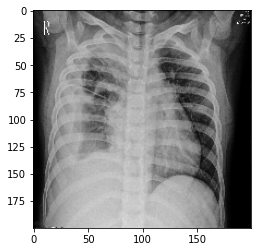

In [ ]:
sample = train[10][0]
rgb = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

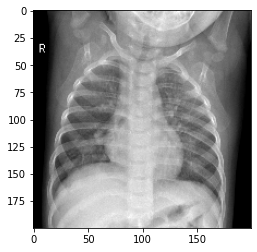

In [ ]:
sample2 = train[4003][0]
rgb2 = cv2.cvtColor(sample2, cv2.COLOR_BGR2RGB)
plt.imshow(rgb2)

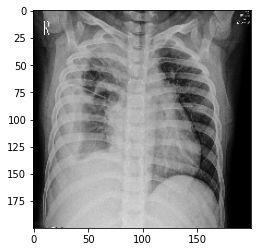

In [ ]:
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray');

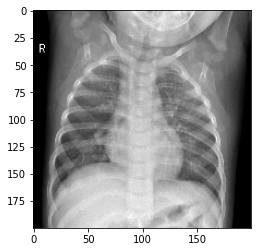

In [ ]:
gray2 = cv2.cvtColor(rgb2, cv2.COLOR_RGB2GRAY)
plt.imshow(gray2, cmap='gray');

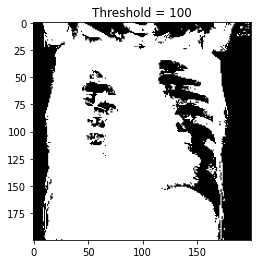

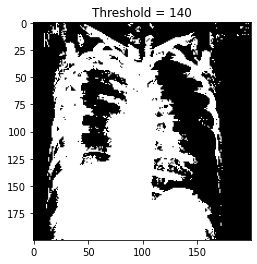

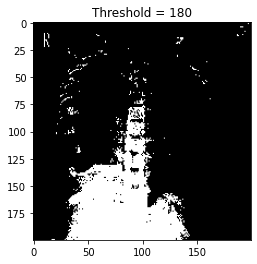

In [ ]:
thresholds = [100, 140, 180]
for threshold in thresholds:
    val, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh, cmap='gray')
    plt.title(f"Threshold = {threshold}")
    plt.show()

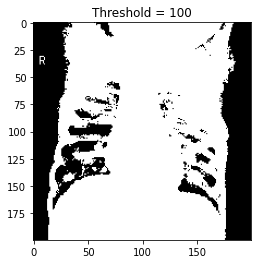

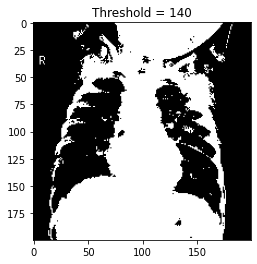

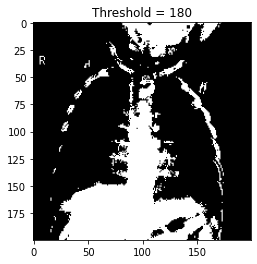

In [ ]:
thresholds = [100, 140, 180]
for threshold in thresholds:
    val, thresh = cv2.threshold(gray2, threshold, 255, cv2.THRESH_BINARY)
    plt.imshow(thresh, cmap='gray')
    plt.title(f"Threshold = {threshold}")
    plt.show()

In [ ]:
def show_threshold(image, threshold):
    cv2_threshs = [cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC,
                  cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV]
    
    names = ['IMAGE_ORIGINAL', 'THRESH_BINARY', 'THRESH_BINARY_INV', 'THRESH_TRUNC',
                'THRESH_TOZERO', 'THRESH_TOZERO_INV']
    
    
    for name, cv2_thresh in zip(names, cv2_threshs):
        val, image_new = cv2.threshold(image, threshold, 255, cv2_thresh)
        plt.imshow(cv2.cvtColor(image_new, cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title(f"Threshold={threshold}, {name}")
        plt.show()

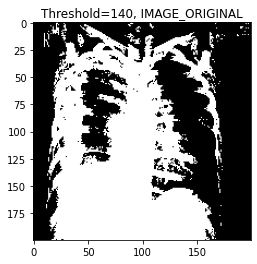

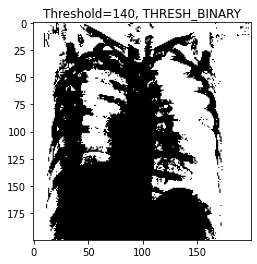

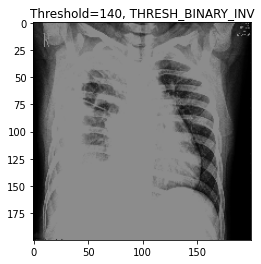

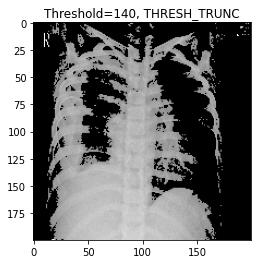

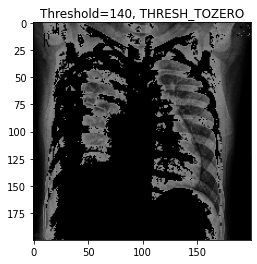

In [ ]:
show_threshold(gray, 140)

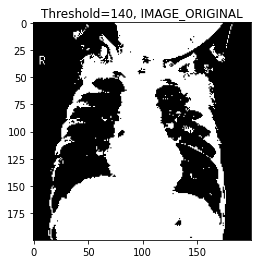

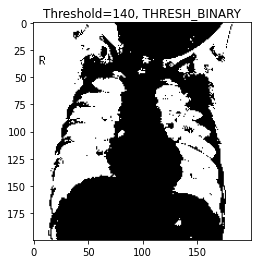

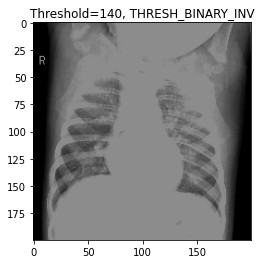

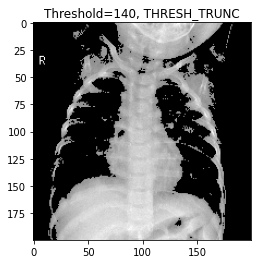

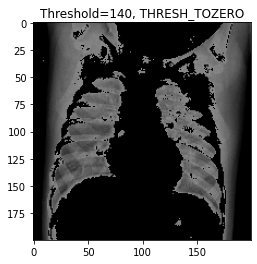

In [ ]:
show_threshold(gray2, 140)

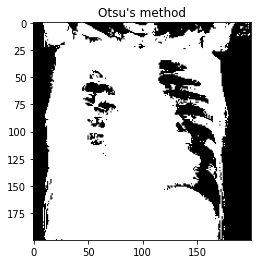

In [ ]:
value, img_otsu = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(cv2.cvtColor(img_otsu, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title(f"Otsu's method")
plt.show()

[[61. 61. 61.]
 [61. 61. 61.]
 [60. 60. 60.]
 ...
 [30. 30. 30.]
 [30. 30. 30.]
 [30. 30. 30.]] (966144, 3)


No handles with labels found to put in legend.


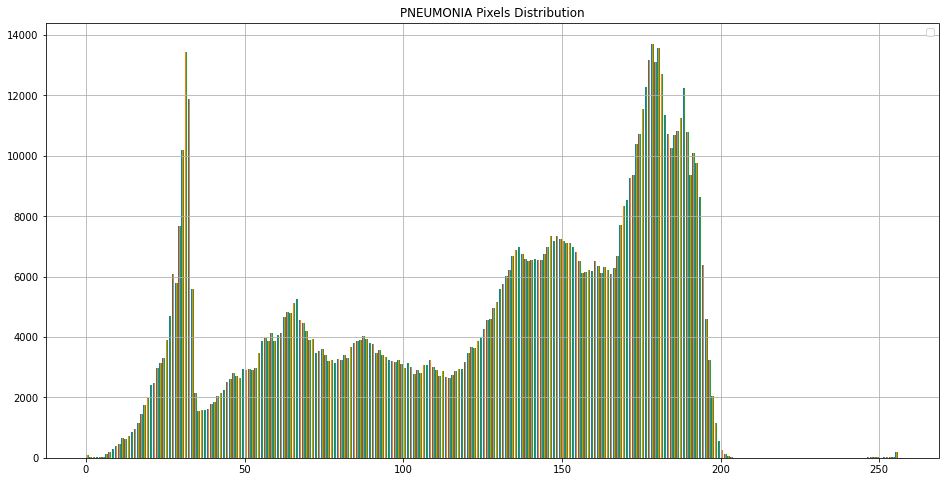

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
img_new = cv2.imread("/content/chest_xray/train/PNEUMONIA/person1004_bacteria_2935.jpeg", 1)
img_vect = img_new.reshape((-1, 3))
img_vect = np.float32(img_vect)

print(img_vect, img_vect.shape)

plt.figure(figsize=(16, 8))
plt.hist(img_vect, 256, [0,256])
plt.title('PNEUMONIA Pixels Distribution')
plt.grid()
plt.legend()
plt.show()


ret, label, centroids = cv2.kmeans(img_vect, 3, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

[[51. 51. 51.]
 [50. 50. 50.]
 [47. 47. 47.]
 ...
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]] (2601600, 3)


No handles with labels found to put in legend.


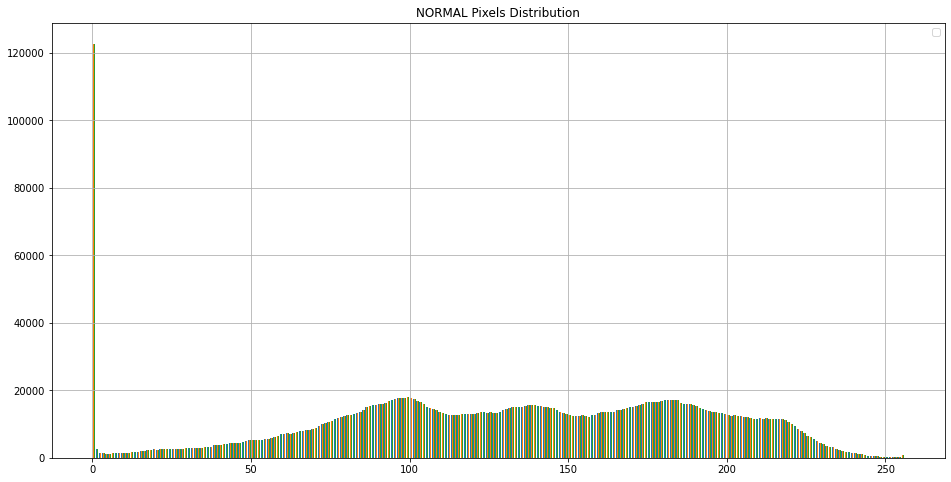

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
img_new = cv2.imread("/content/chest_xray/train/NORMAL/IM-0531-0001.jpeg", 1)
img_vect = img_new.reshape((-1, 3))
img_vect = np.float32(img_vect)

print(img_vect, img_vect.shape)

plt.figure(figsize=(16, 8))
plt.hist(img_vect, 256, [0,256])
plt.title('NORMAL Pixels Distribution')
plt.grid()
plt.legend()
plt.show()


ret, label, centroids = cv2.kmeans(img_vect, 3, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [ ]:
def cross_validation(dataset):
    X_, y_= list(), list()
    for x, y in dataset:
        X_.append(x)
        y_.append(y)
    return X_, y_

def normalize(X):
    return np.array(X) / 255

def reshape(X, y, fig_size):
    X = X.reshape(-1, fig_size[0], fig_size[1], 1)
    y = np.array(y)
    return X, y

def data_argumentation(datagen=None):
    if datagen is None:
        return ImageDataGenerator(
                featurewise_center=False, 
                samplewise_center=False, 
                featurewise_std_normalization=False,  
                samplewise_std_normalization=False, 
                zca_whitening=False,  
                rotation_range = 30) 
    return datagen

In [ ]:
X_train, y_train = cross_validation(train)
X_test, y_test = cross_validation(test)

X_train = normalize(X_train)
X_test = normalize(X_test)

X_train, y_train = reshape(X_train, y_train, (200, 200))
X_test, y_test = reshape(X_test, y_test, (200, 200))

In [ ]:
datagenerator = data_argumentation(None)

In [ ]:
datagenerator.fit(X_train)

In [ ]:
print(f"Train: {len(X_train)}, Test: {len(test)}")

Train: 5216, Test: 624


In [ ]:
def get_model(img_size):
    model = Sequential()
    model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=img_size))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides=2, padding='same'))
    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2), strides = 2, padding='same'))
    model.add(Flatten())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    return model

def get_model2(img_size):
    model2 = Sequential()
    model2.add(Conv2D(32, (3,3), strides=1, padding='VALID', activation='relu', input_shape=img_size))
    model2.add(MaxPool2D((2,2), strides=2, padding='VALID'))
    model2.add(Conv2D(64, (3,3), strides=1, padding='VALID', activation='relu'))
    model2.add(MaxPool2D((2,2), strides=2, padding='VALID'))
    model2.add(Conv2D(128, (3,3), strides=1, padding='VALID', activation='relu'))
    model2.add(MaxPool2D((2,2), strides=2, padding='VALID'))
    model2.add(Conv2D(128, (3,3), strides=1, padding='VALID', activation='relu'))
    model2.add(MaxPool2D((2,2), strides = 2, padding='VALID'))
    model2.add(Flatten())
    model2.add(Dropout(0.5))
    model2.add(Dense(units=512, activation='relu'))
    model2.add(Dense(2, activation='softmax'))
    return model2

def get_callback():
    callbacks_list = [
            keras.callbacks.ModelCheckpoint(
                filepath='lstmchar256256128test.h5',
                monitor='val_loss',
                save_best_only=True
            ),
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0,
                patience=8,
                mode='auto',
                baseline=None,
            )
        ]
    return callbacks_list
def get_callback2():
    callbacks_list2 = [
            keras.callbacks.ModelCheckpoint(
                filepath='lstmchar256256128test.h5',
                monitor='val_loss',
                save_best_only=True
            ),
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0,
                patience=8,
                mode='auto',
                baseline=None,
            )
        ]
    return callbacks_list2

In [ ]:
model = get_model((200, 200, 1))
model2 = get_model2((200, 200, 1))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 100, 100, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 64)     2

In [ ]:
epochs=40
history = model.fit(datagenerator.flow(X_train, y_train, batch_size=32), epochs=epochs, callbacks=get_callback(), steps_per_epoch=20)
history2 = model2.fit(datagenerator.flow(X_train, y_train, batch_size=32), epochs=epochs, callbacks=get_callback(), steps_per_epoch=20)


Epoch 1/40
20/20 [==============================] - 4s 138ms/step - loss: 4.3314 - accuracy: 0.7937
Epoch 2/40
20/20 [==============================] - 3s 137ms/step - loss: 0.3982 - accuracy: 0.8938
Epoch 3/40
20/20 [==============================] - 3s 140ms/step - loss: 0.1875 - accuracy: 0.9266
Epoch 4/40
20/20 [==============================] - 3s 138ms/step - loss: 0.1419 - accuracy: 0.9438
Epoch 5/40
20/20 [==============================] - 3s 136ms/step - loss: 0.1629 - accuracy: 0.9469
Epoch 6/40
20/20 [==============================] - 3s 137ms/step - loss: 0.1322 - accuracy: 0.9578
Epoch 7/40
20/20 [==============================] - 3s 138ms/step - loss: 0.1389 - accuracy: 0.9438
Epoch 8/40
20/20 [==============================] - 3s 145ms/step - loss: 0.1193 - accuracy: 0.9594
Epoch 9/40
20/20 [==============================] - 3s 143ms/step - loss: 0.1253 - accuracy: 0.9547
Epoch 10/40
20/20 [==============================] - 3s 144ms/step - loss: 0.1623 - accuracy: 0.9453

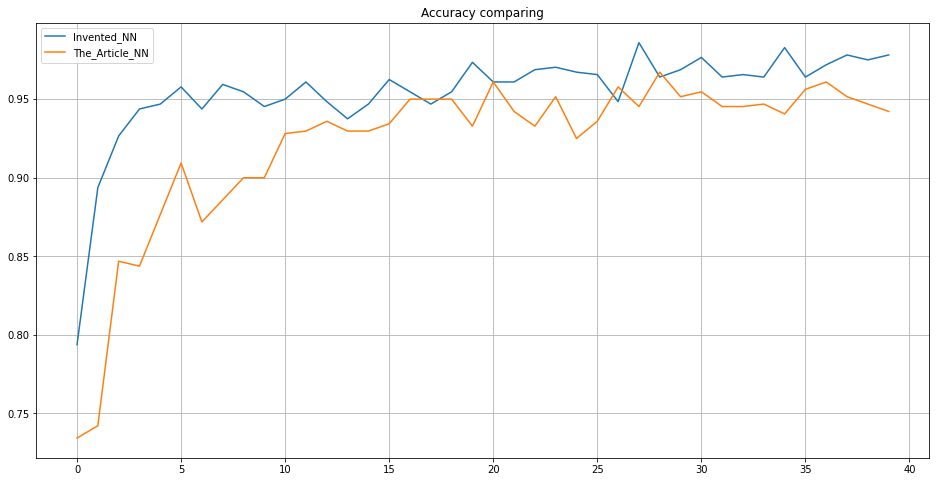

In [ ]:
history_acc = history.history["accuracy"]
history_acc2 = history2.history["accuracy"]

plt.figure(figsize=(16, 8))
plt.plot(history_acc, label="Invented_NN")
plt.plot(history_acc2, label="The_Article_NN")
plt.title("Accuracy comparing")
plt.grid()
plt.legend()
plt.show()

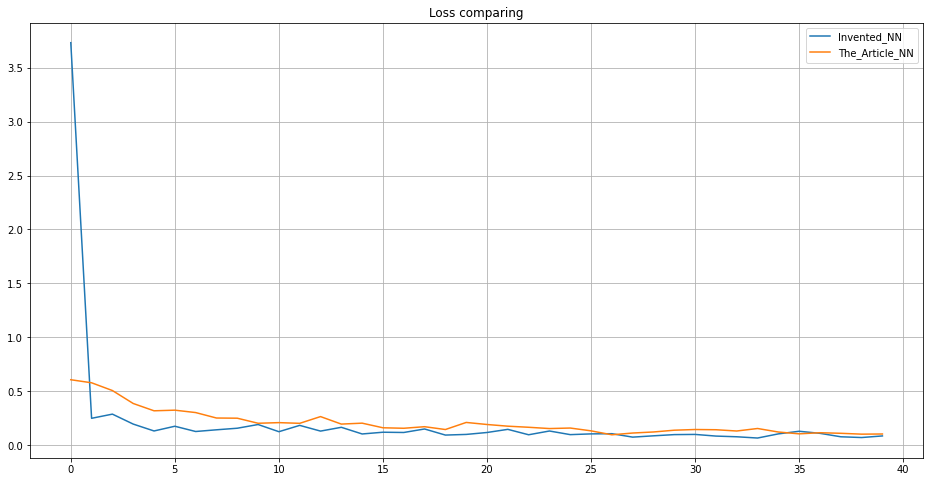

In [ ]:
history_loss = history.history["loss"]
history_loss2 = history2.history["loss"]
plt.figure(figsize=(16, 8))
plt.plot(history_loss, label="Invented_NN")
plt.plot(history_loss2, label="The_Article_NN")
plt.title("Loss comparing")
plt.grid()
plt.legend()
plt.show()

In [ ]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x, axis=1)
classes_x
print(classification_report(y_test, classes_x, target_names=labels))

              precision    recall  f1-score   support

   PNEUMONIA       0.91      0.88      0.90       390
      NORMAL       0.82      0.85      0.84       234

    accuracy                           0.87       624
   macro avg       0.86      0.87      0.87       624
weighted avg       0.88      0.87      0.87       624



In [ ]:
predict_x2=model2.predict(X_test) 
classes_x2=np.argmax(predict_x2, axis=1)
classes_x2
print(classification_report(y_test, classes_x2, target_names=labels))

              precision    recall  f1-score   support

   PNEUMONIA       0.74      0.99      0.85       390
      NORMAL       0.98      0.42      0.59       234

    accuracy                           0.78       624
   macro avg       0.86      0.71      0.72       624
weighted avg       0.83      0.78      0.75       624



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
predict_x_Test=model.predict(X_test) 
classes_x_Test=np.argmax(predict_x_Test, axis=1)

In [ ]:
classes_x_Test

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
predict_x_Test=model.predict(X_test) 
classes_x_Test=np.argmax(predict_x_Test, axis=1)

predict_x_Train=model.predict(X_train) 
classes_x_Train=np.argmax(predict_x_Train, axis=1)

In [ ]:
logistic_Test= confusion_matrix(y_test,classes_x_Test)
logistic_Train= confusion_matrix(y_train,classes_x_Train)

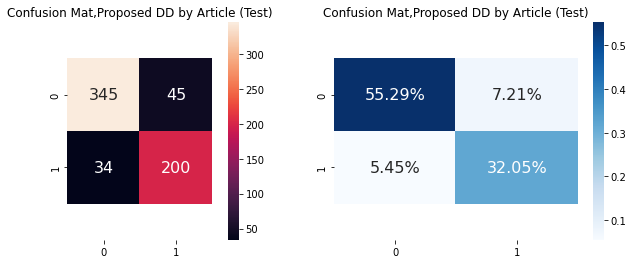

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
ax = sns.heatmap(logistic_Test, square=True, annot=True, fmt='d', annot_kws={"size": 16})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Confusion Mat,Proposed DD by Article (Test)')
plt.subplot(122)
ax = sns.heatmap(logistic_Test/np.sum(logistic_Test), annot=True, annot_kws={"size": 16},
            fmt='.2%', cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Confusion Mat,Proposed DD by Article (Test)')
plt.show()

In [ ]:
predict_x_Test=model2.predict(X_test) 
classes_x_Test=np.argmax(predict_x_Test, axis=1)

predict_x_Train=model2.predict(X_train) 
classes_x_Train=np.argmax(predict_x_Train, axis=1)

In [ ]:
logistic_Test= confusion_matrix(y_test,classes_x_Test)
logistic_Train= confusion_matrix(y_train,classes_x_Train)

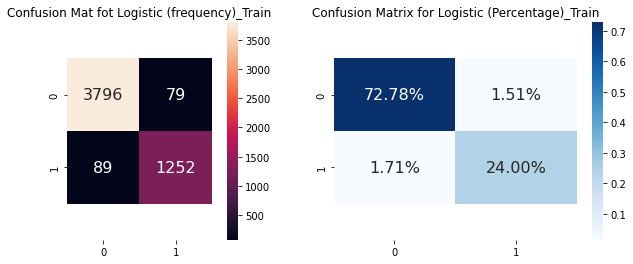

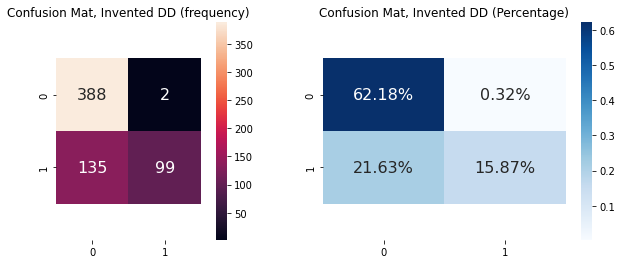

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
ax = sns.heatmap(logistic_Train, square=True, annot=True, fmt='d', annot_kws={"size": 16})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Confusion Mat fot Logistic (frequency)_Train')
plt.subplot(122)
ax = sns.heatmap(logistic_Train/np.sum(logistic_Train), annot=True, annot_kws={"size": 16},
            fmt='.2%', cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Confusion Matrix for Logistic (Percentage)_Train')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(121)
ax = sns.heatmap(logistic_Test, square=True, annot=True, fmt='d', annot_kws={"size": 16})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Confusion Mat, Invented DD (frequency)')
plt.subplot(122)
ax = sns.heatmap(logistic_Test/np.sum(logistic_Test), annot=True, annot_kws={"size": 16},
            fmt='.2%', cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Confusion Mat, Invented DD (Percentage)')
plt.show()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
pip install visualkeras

     |████████████████████████████████| 992 kB 3.1 MB/s 


In [ ]:
import visualkeras

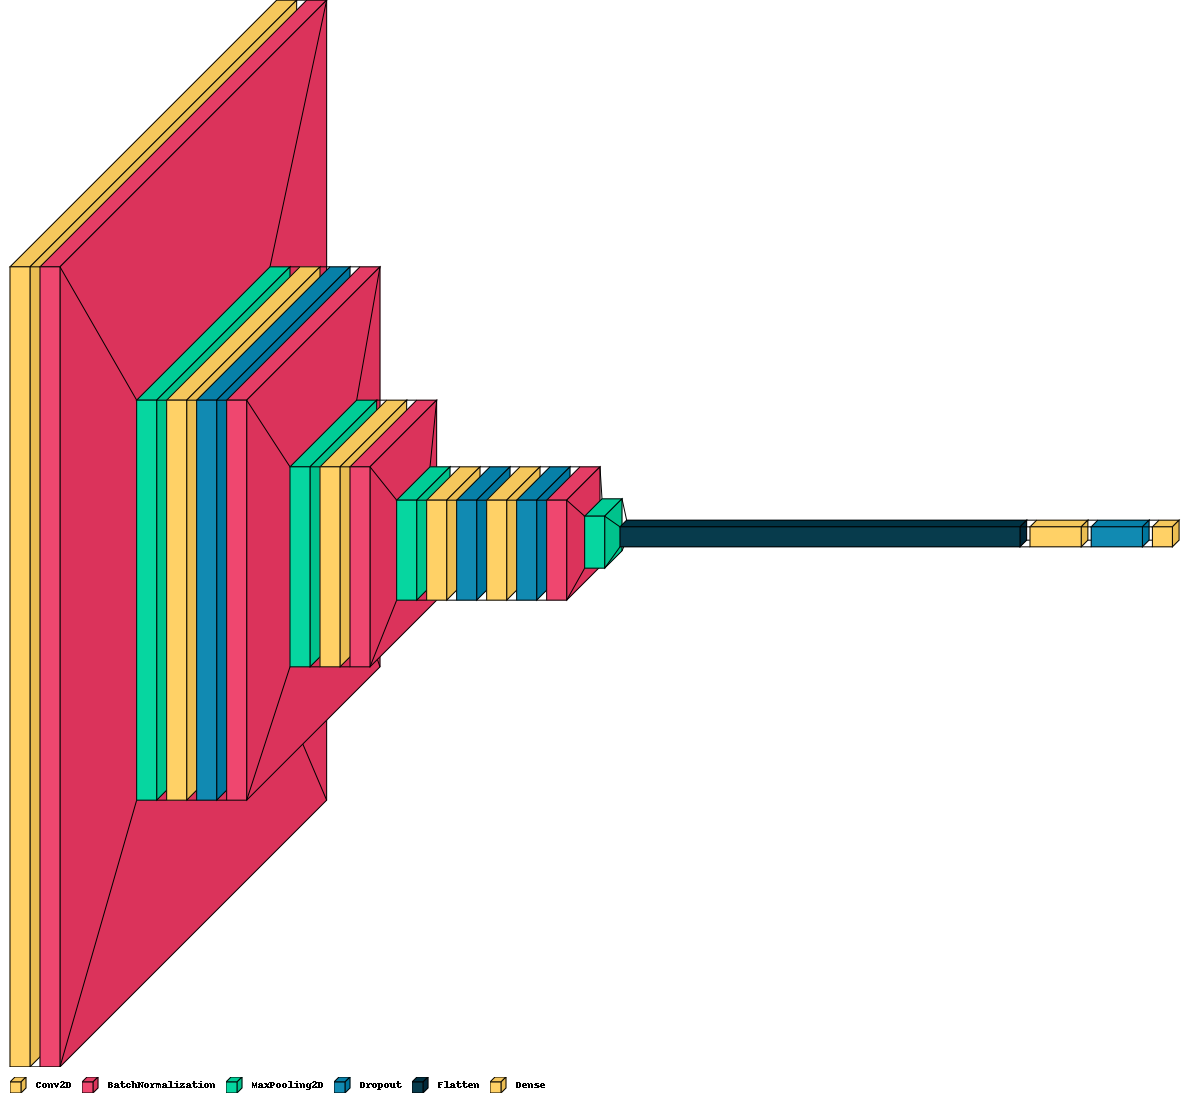

In [ ]:
visualkeras.layered_view(model).show() # display using your system viewer
from PIL import ImageFont

visualkeras.layered_view(model2, legend=True)  # font is optional!
visualkeras.layered_view(model, legend=True, to_file='output.png') # write to disk